# 1 Setup

## Install Dependencies

In [1]:
! pip install opencv-python matplotlib

## Import Dependencies

In [1]:
# Import Standard Dependencies
import os
import numpy as np 
import random
import matplotlib.pyplot as plt
import cv2 

In [2]:
# Import tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf 

## Set GPU-Growth

In [3]:
# Avoiding Out of Memory(OOM) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU') #getting access to all the gpus available on the machine
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Creating Folder Structures

In [5]:
# setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
POS_PATH

'data\\positive'

In [8]:
os.makedirs(POS_PATH)

In [9]:
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2.Collect Positives and Anchors

### Untar Labelled Faces in the Wild Dataser

In [6]:
# Uncompressing TAR GZ file in the Wild Dataset
!tar -xf lfw.tgz

^C


In [12]:
# Move lfw imgages to the following repository: data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

### Collect Positive and Anchor Class Images

In [7]:
# Importing UUID library for generating unique image names
import uuid

In [8]:
cap = cv2.VideoCapture(0)
while cap:
    ret, frame = cap.read()
    
    # to capture the face only : 250 * 250 pixels
    frame = frame[120:120+250, 200:200+250, :]
    
    # collect anchors: press A to start collecting anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):   
       #create a unique file path
       imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
       cv2.imwrite(imgname, frame) 
    
    # collect positives: press P to start collecting positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        #create a unique file path
       imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
       cv2.imwrite(imgname, frame) 
    
    cv2.imshow('Collecting Image Samples', frame)
    
    if cv2.waitKey(1) & 0xFF == 27:   # press 'Esc' key to quit
        break
    
cap.release()
cv2.destroyAllWindows()

# 3.Load and Preprocess Images

### Get Image Directories

In [8]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300) # grabbing 300 files with .jpg 
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [9]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\5fc4225f-590f-11ec-9728-309c2393f9a0.jpg'

### Preprocessing- Scale and Resize

In [10]:
def preprocess(file_path):
    # read in image from file path
    byte_img = tf.io.read_file(file_path)
    # load image
    img = tf.io.decode_jpeg(byte_img)
    
    # resizing the image to 100 x 100 x 3
    img = tf.image.resize(img, (100,100))
    # scale image to be between 0 and 1
    img = img / 255.0
    return img

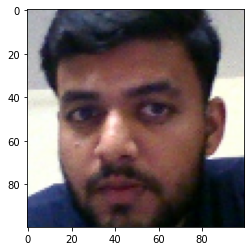

In [11]:
img = preprocess('data\\anchor\\5665b544-590f-11ec-9d8e-309c2393f9a0.jpg')
plt.imshow(img)

In [12]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.6752451 , 0.6909314 , 0.7262255 ],
        [0.69240195, 0.7002451 , 0.7267157 ],
        [0.68210787, 0.6781863 , 0.6985294 ],
        ...,
        [0.7708333 , 0.75416666, 0.75514704],
        [0.7296569 , 0.71887255, 0.7375    ],
        [0.7318627 , 0.720098  , 0.747549  ]],

       [[0.6718137 , 0.68897057, 0.72132355],
        [0.6698529 , 0.67769605, 0.70416665],
        [0.68088233, 0.6732843 , 0.69534314],
        ...,
        [0.7205882 , 0.71568626, 0.7107843 ],
        [0.7769608 , 0.76911765, 0.7848039 ],
        [0.7490196 , 0.7352941 , 0.7617647 ]],

       [[0.6735294 , 0.702451  , 0.7252451 ],
        [0.6987745 , 0.7078431 , 0.7355392 ],
        [0.702451  , 0.69779414, 0.7235294 ],
        ...,
        [0.75759804, 0.75784314, 0.7441176 ],
        [0.7468137 , 0.74191177, 0.7370098 ],
        [0.76617646, 0.7495098 , 0.7563726 ]],

       ...,

       [[0.15318628, 0.22181372, 0.3875    ],
        [0.12

### Create Labelled Dataset

In [28]:
tf.ones_like([1, 1.5, 2.0130, 0.000000004])

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

In [29]:
# (anchor, positive) --> 1, 1, 1, 1
# (anchor, negative) --> 0, 0, 0, 0

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [30]:
len(data)

600

### Build Train and Test partitions

In [31]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [32]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [33]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [34]:
samples = data.as_numpy_iterator()

In [35]:
samp = samples.next()

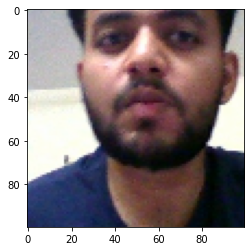

In [36]:
# anchor image
plt.imshow(samp[0])

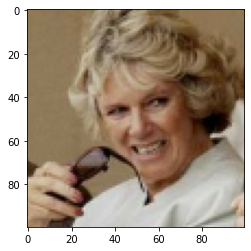

In [95]:
# negative image
plt.imshow(samp[1])

In [96]:
# label of negative image --> 0
print(samp[2])

0.0


In [37]:
# training partitions

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [38]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [39]:
len(train_data)

27

In [40]:
# testing data
test_data = data.skip(round(len(data)*.7)) # skipped 70% of data
test_data = test_data.take(round(len(data)*0.3)) # grabbed 30% of data
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4.Model Engineering

### Building Embedding Layer

In [14]:
def make_embedding():
    inp = Input(shape= (100,100,3), name= 'input_image')
    
    # first block
    c1 = Conv2D(filters=64, kernel_size=(10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # second block
    c2 = Conv2D(filters=128, kernel_size=(7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # third block
    c3 = Conv2D(filters=128, kernel_size=(4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # fourth block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [15]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Building Distance Layer

In [16]:
class L1Dist(Layer):
    def __init__(self, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super().__init__(trainable=trainable, name=name, dtype=dtype, dynamic=dynamic, **kwargs)
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [17]:
l1 = L1Dist()

### Make Siamese Model

In [18]:
def make_siamese_model():
    
    # anchor image
    input_image = Input(name='input_image', shape=(100, 100, 3))
    
    # validation image
    validation_image = Input(name='validation_image', shape=(100, 100, 3))
    
    # combining siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [19]:
siamese_model = make_siamese_model()

# 5.Training

### Setup Loss and Optimizer

In [20]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [21]:
opt = tf.keras.optimizers.Adam(1e-4)

### Establish Checkpoints

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Build Train Step Function

In [23]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        # get anchor and postitive/negative image
        X = batch[:2]
        
        # get label
        y = batch[2]
    
    
        # Forward pass
        yhat = siamese_model(X, training=True)
        
        # calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)

    # Calculate Gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

### Build Training Loop

In [24]:
def train(data, EPOCHS):
    # loop through each epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
    
        # loop through each batch
        for idx, batch in enumerate(data):
            # run train step here
            train_step(batch)
            progbar.update(idx+1)
            
        # save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train the model

In [25]:
EPOCHS = 50

In [132]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 28s 730ms/step

 Epoch 2/50
27/27 [==============================] - 19s 736ms/step

 Epoch 3/50
27/27 [==============================] - 19s 734ms/step

 Epoch 4/50
27/27 [==============================] - 19s 734ms/step

 Epoch 5/50
27/27 [==============================] - 19s 733ms/step

 Epoch 6/50
27/27 [==============================] - 19s 732ms/step

 Epoch 7/50
27/27 [==============================] - 19s 739ms/step

 Epoch 8/50
27/27 [==============================] - 20s 751ms/step

 Epoch 9/50
27/27 [==============================] - 20s 758ms/step

 Epoch 10/50
27/27 [==============================] - 20s 767ms/step

 Epoch 11/50
27/27 [==============================] - 20s 758ms/step

 Epoch 12/50
27/27 [==============================] - 20s 765ms/step

 Epoch 13/50
2

# 6.Evaluating Model

In [26]:
#Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

### Making Predictions

In [41]:
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [42]:
# make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[0.50024027],
       [0.4998642 ],
       [0.4993149 ],
       [0.50020456],
       [0.49942797],
       [0.5001985 ],
       [0.4998483 ],
       [0.5009673 ],
       [0.4998956 ],
       [0.5001634 ],
       [0.50022   ],
       [0.4989063 ],
       [0.50027186],
       [0.50014246],
       [0.49986008],
       [0.4994833 ]], dtype=float32)

In [43]:
# converting results to binary values
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0]

In [44]:
y_true

array([0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
      dtype=float32)

### Calculating Metrics

In [45]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

0.41666666

In [46]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

0.625

### Visualizing Results

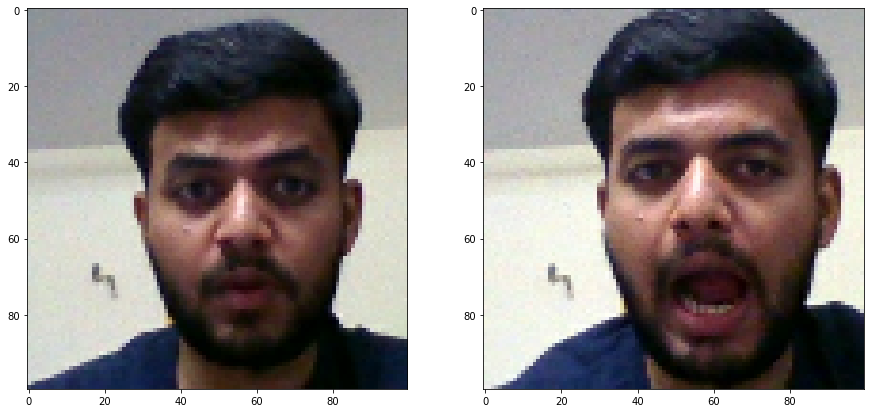

In [47]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[1])

plt.subplot(1,2,2)
plt.imshow(test_val[1])

plt.show()

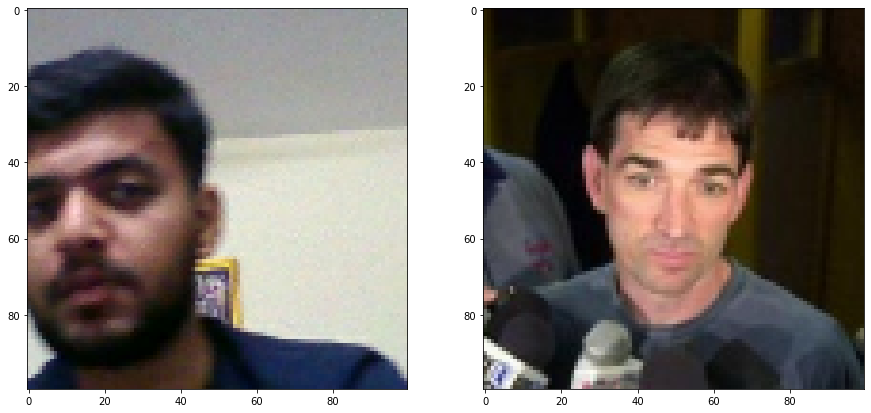

In [150]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
plt.imshow(test_input[2])

plt.subplot(1,2,2)
plt.imshow(test_val[2])

plt.show()

# 7.Save Model

In [167]:
# save weights
siamese_model.save('siamesemodel.h5')

In [48]:
# reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

# 8.Real Time Test

### Verification Function

In [49]:
# frame  --> input_image
# model --> siamese neural network
# detection_threshold --> metric above which a prediction is considered positive
# verification_threshold --> proportion of positive predictions / total positive samples

def verify(model, detection_threshold, verification_threshold):
    # build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # make predictions                            
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results, verified

### OpenCV Real Time Verification

In [62]:
cap = cv2.VideoCapture(0)
while cap:
    ret, frame = cap.read()
    
    # to capture the face only : 250 * 250 pixels
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # verification key ---> v
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save input image
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        
        # run verification
        results, verified = verify(model, 0.5, 0.9)
        print(verified)

    
    if cv2.waitKey(10) & 0xFF == 27:
        break
    
    
cap.release()
cv2.destroyAllWindows()

False
True
True
False
False
False
True
